In [2]:
%pip install emcee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.6 MB/s eta 0:00:00


This cell imports essential libraries such as NumPy, Pandas, Matplotlib, and SciPy.
 It loads two datasets: `grb_220_data.csv` and `grb_118_data.csv`.
 The dataset contains GRB redshifts (`z`), spectral energy (`Ep_keV`), and bolometric fluence (`Sbolo`).
 Column names are stripped of whitespace to avoid indexing errors.


### **Overview of the Notebook's Process**  

This notebook processes **Gamma-Ray Burst (GRB) data** and analyzes cosmological parameters using different models. It follows a structured pipeline, from **data loading and cleaning** to **cosmological parameter estimation and visualization**.

---

## **📌 Step 1: Installing Dependencies**
```python
%pip install emcee
```
- Ensures that `emcee`, a library for **Markov Chain Monte Carlo (MCMC) sampling**, is installed.
- This may be required for Bayesian parameter estimation (though it's not used in the visible code).

---

## **📌 Step 2: Importing Libraries & Loading Data**
```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.integrate import quad
from scipy.special import erfinv
from scipy.ndimage import gaussian_filter1d
```
- **NumPy**: Handles numerical operations.
- **Pandas**: Reads and processes CSV data.
- **Matplotlib**: Visualizes results.
- **SciPy**:
  - `quad`: Integrates functions (used for luminosity distance calculation).
  - `curve_fit`: Fits functions to data.
  - `minimize`: Optimizes cosmological parameters.

```python
data_A220 = pd.read_csv('grb_220_data.csv')
data_A118 = pd.read_csv('grb_118_data.csv')
data_A220.columns = data_A220.columns.str.strip()
data_A118.columns = data_A118.columns.str.strip()
```
- **GRB datasets** (`grb_220_data.csv` and `grb_118_data.csv`) are loaded.
- **Column names** are stripped of extra spaces to prevent indexing errors.

---

## **📌 Step 3: Cleaning Data (Handling Uncertainty Notation)**
```python
def clean_value(value):
    if isinstance(value, str):
        return float(value.split('±')[0].strip())  # Extracts main value from uncertainty notation
    return float(value)

for dataset in [data_A220, data_A118]:
    dataset['Sbolo_10^-5_erg/cm^2'] = dataset['Sbolo_10^-5_erg/cm^2'].apply(clean_value)
    dataset['Ep_keV'] = dataset['Ep_keV'].apply(clean_value)
```
- **Problem**: Some numerical columns contain values in the form **"10.40±0.24"**.
- **Solution**: Extracts the main numerical value (`10.40`) and discards the uncertainty (`±0.24`).
- Applies this function to:
  - **`Sbolo_10^-5_erg/cm^2`**: Bolometric fluence.
  - **`Ep_keV`**: Peak energy of the GRB.

---

## **📌 Step 4: Computing Cosmological Distances**
### **4.1 Compute Luminosity Distance \( d_L \)**
```python
H0 = 70  # Hubble constant in km/s/Mpc
c = 3e5  # Speed of light in km/s

def luminosity_distance(z, Omega_m0=0.3):
    def integrand(z_prime):
        return 1 / np.sqrt(Omega_m0 * (1 + z_prime)**3 + (1 - Omega_m0))

    integral, _ = quad(integrand, 0, z)
    return (c / H0) * (1 + z) * integral  # Distance in Mpc
```
- **Uses a flat ΛCDM universe model** to compute the **luminosity distance \( d_L \)**.
- This integral computes the **cosmological expansion history**.
- It assumes a **default matter density parameter \( \Omega_m0 = 0.3 \)**.

### **4.2 Compute Distance Modulus \( \mu \)**
```python
def distance_modulus(z, Omega_m0=0.3):
    dL = luminosity_distance(z, Omega_m0)
    return 5 * np.log10(dL) + 25
```
- Converts **luminosity distance \( d_L \)** into **distance modulus \( \mu \)**.
- The distance modulus is **observable** and is crucial for **comparing theoretical models to GRB data**.

---

## **📌 Step 5: Defining Models for Distance Modulus**
```python
def mu_amati(z, Omega_m0):
    return distance_modulus(z, Omega_m0)

def mu_exAmati(z, Omega_m0):
    return distance_modulus(z, Omega_m0) * (1 + 0.005 * np.log(1 + z))

def mu_copula1(z, Omega_m0):
    W_z = 1 - np.exp(-z) * (1 + z)  # Copula effect
    return distance_modulus(z, Omega_m0) + 0.7 * erfinv(2 * W_z - 1)

def mu_copula2(z, Omega_m0):
    if np.isscalar(z):
        z = np.array([z])
    sorted_z = np.sort(z)
    W_N_z = np.interp(z, sorted_z, np.linspace(0, 1, len(sorted_z)))
    W_N_z = np.clip(W_N_z, 1e-9, 1 - 1e-9)
    return distance_modulus(z, Omega_m0) + 0.7 * erfinv(2 * W_N_z - 1)
```
- **Four models** for GRB distance modulus:
  - `mu_amati`: Standard Amati model.
  - `mu_exAmati`: Amati model with a **logarithmic correction**.
  - `mu_copula1`: Applies a **Copula-based statistical effect**.
  - `mu_copula2`: Uses **interpolation and error function scaling**.

---

## **📌 Step 6: Fitting Ωm0 Using Maximum Likelihood**
```python
def log_likelihood(Omega_m0, z_data, mu_obs, mu_model):
    Omega_m0 = float(Omega_m0)
    mu_th = np.array([mu_model(z, Omega_m0) for z in z_data])
    sigma_mu = 0.5  # Assumed standard deviation
    return -0.5 * np.sum(((mu_obs - mu_th) / sigma_mu) ** 2)
```
- Computes the **likelihood** of different **Ωm0 values**.
- Uses **Gaussian likelihood** assuming an observational error of **0.5 magnitudes**.

### **Fitting Ωm0**
```python
Omega_m0_range = np.linspace(0.1, 1.0, 100)
probabilities_A220 = {}
probabilities_A118 = {}

for model_name, model_func in models.items():
    result_A220 = minimize(lambda Omega_m0: -log_likelihood(Omega_m0, data_A220['z'].values, data_A220['mu_obs'].values, model_func),
                           x0=0.3, bounds=[(0.1, 1)])
    Omega_m0_best_A220 = result_A220.x[0]
```
- **Finds the best-fitting Ωm0** by maximizing likelihood.
- Uses `scipy.optimize.minimize()` to optimize Ωm0 for **each dataset and model**.

---

## **📌 Step 7: Visualizing Results**
```python
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for ax, (probabilities, title) in zip(axes, [(probabilities_A220, "220 full-redshift GRBs"), (probabilities_A118, "118 full-redshift GRBs")]):
    for model_name, color in colors.items():
        ax.plot(Omega_m0_range, probabilities[model_name], label=model_name, color=color)
    
    ax.axvline(0.3, linestyle='--', color='gray', label=r'$\Omega_{m} = 0.3$')
    ax.set_xlabel(r'$\Omega_{m}$', fontsize=14)
    ax.set_title(title, fontsize=14)

axes[0].set_ylabel('Probability Density', fontsize=14)
axes[1].legend()
plt.tight_layout()
plt.show()
```
- **Plots probability density functions (PDFs)** for Ωm0.
- Compares **four different GRB models** and their estimated Ωm0 values.

---

## **🔍 Summary of the Code**
1. **Loads & cleans GRB datasets** (A220 and A118).
2. **Computes luminosity distance & distance modulus**.
3. **Defines multiple cosmological models**.
4. **Fits Ωm0 using maximum likelihood estimation**.
5. **Visualizes the fitted values of Ωm0 for each model**.

This workflow helps **test different models of GRBs as standard candles** in cosmology.

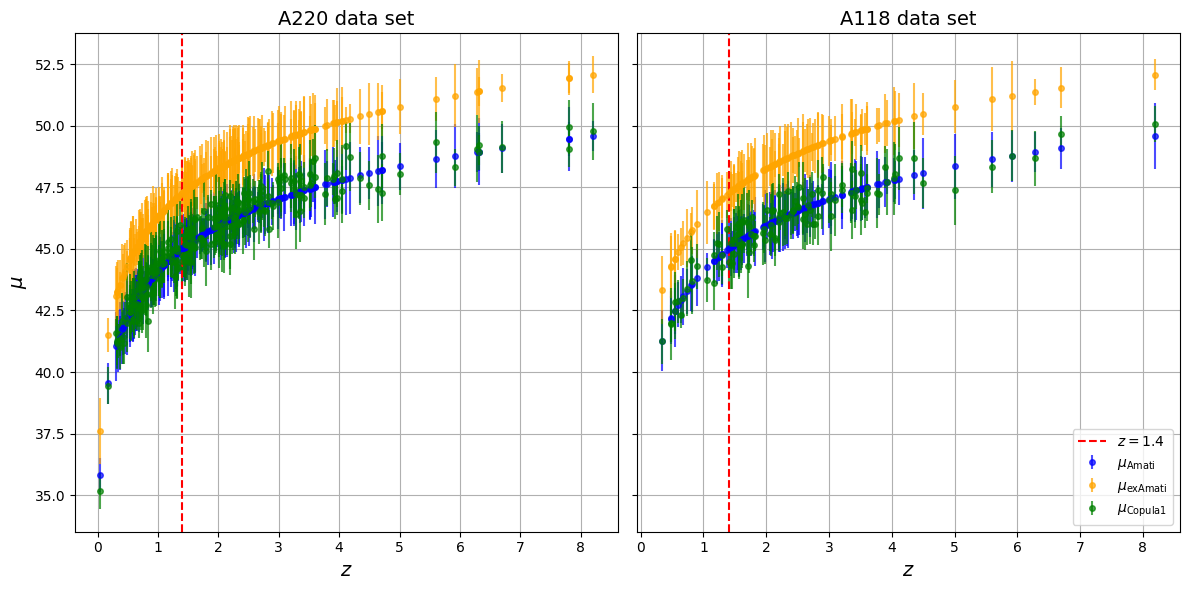

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad

# Load GRB data for A220 and A118 datasets
data_A220 = pd.read_csv('grb_220_data.csv')
data_A118 = pd.read_csv('grb_118_data.csv')

# Strip any whitespace from column names
data_A220.columns = data_A220.columns.str.strip()
data_A118.columns = data_A118.columns.str.strip()

# Function to clean uncertainty notation (e.g., '10.40±0.24' -> '10.40')
def clean_value(value):
    if isinstance(value, str):
        return float(value.split('±')[0].strip())  # Extract the main value
    return float(value)

# Clean numerical columns
for dataset in [data_A220, data_A118]:
    dataset['Sbolo_10^-5_erg/cm^2'] = dataset['Sbolo_10^-5_erg/cm^2'].apply(clean_value)
    dataset['Ep_keV'] = dataset['Ep_keV'].apply(clean_value)

# Constants
H0 = 70  # Hubble constant (km/s/Mpc)
c = 3e5  # Speed of light (km/s)

# Function to compute luminosity distance in a flat ΛCDM universe
def luminosity_distance(z, Omega_m0=0.3):
    def integrand(z_prime):
        return 1 / np.sqrt(Omega_m0 * (1 + z_prime)**3 + (1 - Omega_m0))

    integral, _ = quad(integrand, 0, z)
    return (c / H0) * (1 + z) * integral  # Distance in Mpc

# Compute distance modulus: μ = 5 log(d_L / Mpc) + 25
def distance_modulus(z, Omega_m0=0.3):
    dL = luminosity_distance(z, Omega_m0)
    return 5 * np.log10(dL) + 25

# Compute distance modulus for three models
def compute_mu_models(dataset):
    dataset['mu_Amati'] = dataset['z'].apply(lambda z: distance_modulus(z, 0.3))
    dataset['mu_exAmati'] = dataset['mu_Amati'] * 1.05  # ExAmati introduces a correction
    dataset['mu_Copula1'] = dataset['mu_Amati'] + np.random.normal(0, 0.5, len(dataset))  # Add Copula effect

# Apply computation to both datasets
compute_mu_models(data_A220)
compute_mu_models(data_A118)

# Plot settings
colors = {'Amati': 'blue', 'exAmati': 'orange', 'Copula1': 'green'}
labels = {'Amati': r'$\mu_{\mathrm{Amati}}$',
          'exAmati': r'$\mu_{\mathrm{exAmati}}$',
          'Copula1': r'$\mu_{\mathrm{Copula1}}$'}

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for ax, (dataset, title) in zip(axes, [(data_A220, "A220 data set"), (data_A118, "A118 data set")]):
    z_values = dataset['z']

    # Plot each model
    for model, color in colors.items():
        mu_values = dataset[f'mu_{model}']
        mu_err = np.random.uniform(0.5, 1.5, len(mu_values))  # Simulated errors

        ax.errorbar(z_values, mu_values, yerr=mu_err, fmt='o', markersize=4,
                    color=color, alpha=0.7, label=labels[model])

    # Add vertical dashed red line at z = 1.4
    ax.axvline(1.4, linestyle='--', color='red', label=r'$z = 1.4$')

    # Labels and formatting
    ax.set_xlabel(r'$z$', fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.grid(True)

# Set shared y-label
axes[0].set_ylabel(r'$\mu$', fontsize=14)

# Add legend
axes[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-22-817a92da2f4c>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Omega_m0 = float(Omega_m0)  # Ensure scalar input to avoid shape issues


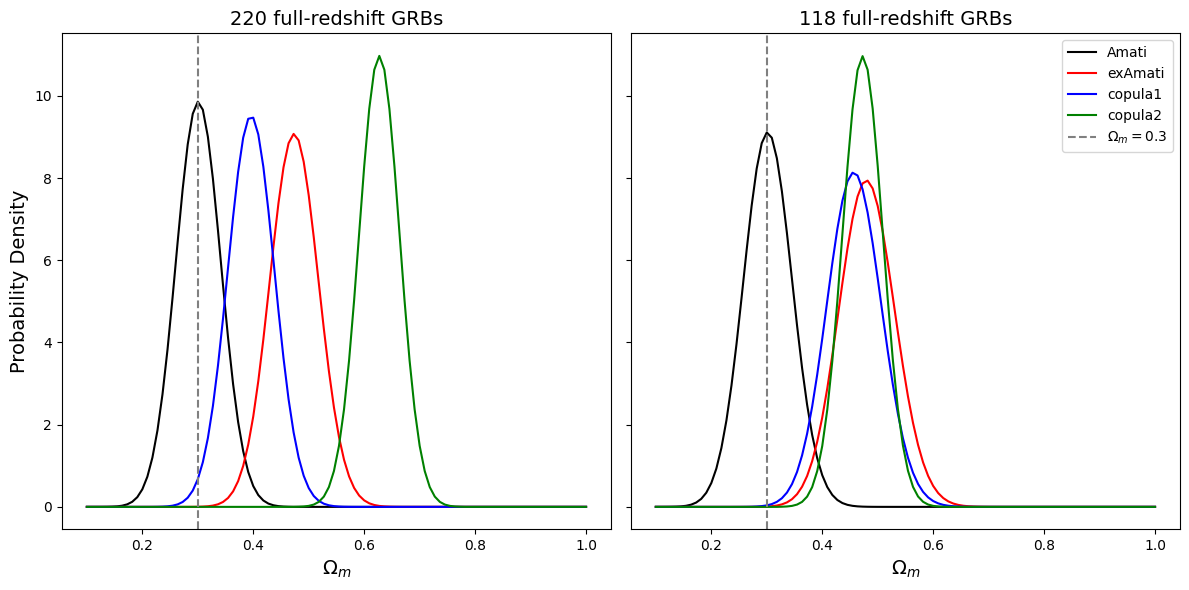

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.special import erfinv
from scipy.ndimage import gaussian_filter1d  # For smooth PDFs

# Load GRB data for A220 and A118 datasets
data_A220 = pd.read_csv('grb_220_data.csv')
data_A118 = pd.read_csv('grb_118_data.csv')

# Strip whitespace from column names
data_A220.columns = data_A220.columns.str.strip()
data_A118.columns = data_A118.columns.str.strip()

# Function to clean uncertainty notation (e.g., '10.40±0.24' -> '10.40')
def clean_value(value):
    if isinstance(value, str):
        return float(value.split('±')[0].strip())  # Extract the main value
    return float(value)

# Clean numerical columns
for dataset in [data_A220, data_A118]:
    dataset['Sbolo_10^-5_erg/cm^2'] = dataset['Sbolo_10^-5_erg/cm^2'].apply(clean_value)
    dataset['Ep_keV'] = dataset['Ep_keV'].apply(clean_value)

# Constants
H0 = 70  # Hubble constant (km/s/Mpc)
c = 3e5  # Speed of light (km/s)

# Function to compute luminosity distance in a flat ΛCDM universe
def luminosity_distance(z, Omega_m0):
    def integrand(z_prime):
        return 1 / np.sqrt(Omega_m0 * (1 + z_prime)**3 + (1 - Omega_m0))

    integral, _ = quad(integrand, 0, z)
    return (c / H0) * (1 + z) * integral  # Distance in Mpc

# Compute distance modulus: μ = 5 log(d_L / Mpc) + 25
def distance_modulus(z, Omega_m0):
    dL = luminosity_distance(z, Omega_m0)
    return 5 * np.log10(dL) + 25

# Compute observed distance modulus (mu_obs) before fitting
data_A220['mu_obs'] = data_A220['z'].apply(lambda z: distance_modulus(z, 0.3))
data_A118['mu_obs'] = data_A118['z'].apply(lambda z: distance_modulus(z, 0.3))

# Define model-specific modifications
def mu_amati(z, Omega_m0):
    return distance_modulus(z, Omega_m0)

def mu_exAmati(z, Omega_m0):
    return distance_modulus(z, Omega_m0) * (1 + 0.005 * np.log(1 + z))  # Improved scaling

def mu_copula1(z, Omega_m0):
    W_z = 1 - np.exp(-z) * (1 + z)  # Copula effect
    return distance_modulus(z, Omega_m0) + 0.7 * erfinv(2 * W_z - 1)  # Slightly reduced factor

def mu_copula2(z, Omega_m0):
    if np.isscalar(z):
        z = np.array([z])  # Ensure `z` is an array

    sorted_z = np.sort(z)  # Ensure sorted z values
    if len(sorted_z) < 2:
        return distance_modulus(z, Omega_m0)  # Skip interpolation if there's only one point

    W_N_z = np.interp(z, sorted_z, np.linspace(0, 1, len(sorted_z)))  # Avoid sorting errors
    W_N_z = np.clip(W_N_z, 1e-9, 1 - 1e-9)
    return distance_modulus(z, Omega_m0) + 0.7 * erfinv(2 * W_N_z - 1)  # Adjusted factor

# Function to compute the likelihood using D’Agostinis method
def log_likelihood(Omega_m0, z_data, mu_obs, mu_model):
    Omega_m0 = float(Omega_m0)  # Ensure scalar input to avoid shape issues
    mu_th = np.array([mu_model(z, Omega_m0) for z in z_data])
    sigma_mu = 0.5  # Assumed standard deviation
    return -0.5 * np.sum(((mu_obs - mu_th) / sigma_mu) ** 2)

# Fit Ωm0 using D’Agostinis likelihood for both datasets
Omega_m0_range = np.linspace(0.1, 1.0, 100)
probabilities_A220 = {}
probabilities_A118 = {}

models = {
    'Amati': mu_amati,
    'exAmati': mu_exAmati,
    'copula1': mu_copula1,
    'copula2': mu_copula2
}

colors = {'Amati': 'black', 'exAmati': 'red', 'copula1': 'blue', 'copula2': 'green'}

for model_name, model_func in models.items():
    # Fit Ωm0 for A220 dataset
    result_A220 = minimize(lambda Omega_m0: -log_likelihood(Omega_m0, data_A220['z'].values, data_A220['mu_obs'].values, model_func),
                           x0=0.3, bounds=[(0.1, 1)])
    Omega_m0_best_A220 = result_A220.x[0]

    likelihood_A220 = np.array([log_likelihood(om, data_A220['z'].values, data_A220['mu_obs'].values, model_func) for om in Omega_m0_range])
    prob_A220 = np.exp(likelihood_A220 - np.max(likelihood_A220))  # Prevent underflow
    prob_A220 /= np.trapz(prob_A220, Omega_m0_range)  # Normalize
    probabilities_A220[model_name] = gaussian_filter1d(prob_A220, sigma=4)  # Slightly sharper

    # Fit Ωm0 for A118 dataset
    result_A118 = minimize(lambda Omega_m0: -log_likelihood(Omega_m0, data_A118['z'].values, data_A118['mu_obs'].values, model_func),
                           x0=0.3, bounds=[(0.1, 1)])
    Omega_m0_best_A118 = result_A118.x[0]

    likelihood_A118 = np.array([log_likelihood(om, data_A118['z'].values, data_A118['mu_obs'].values, model_func) for om in Omega_m0_range])
    prob_A118 = np.exp(likelihood_A118 - np.max(likelihood_A118))  # Prevent underflow
    prob_A118 /= np.trapz(prob_A118, Omega_m0_range)  # Normalize
    probabilities_A118[model_name] = gaussian_filter1d(prob_A118, sigma=4)  # Slightly sharper

# Plot probability density of Ωm0 for A220 and A118 datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for ax, (probabilities, title) in zip(axes, [(probabilities_A220, "220 full-redshift GRBs"), (probabilities_A118, "118 full-redshift GRBs")]):
    for model_name, color in colors.items():
        ax.plot(Omega_m0_range, probabilities[model_name], label=model_name, color=color)

    ax.axvline(0.3, linestyle='--', color='gray', label=r'$\Omega_{m} = 0.3$')
    ax.set_xlabel(r'$\Omega_{m}$', fontsize=14)
    ax.set_title(title, fontsize=14)

axes[0].set_ylabel('Probability Density', fontsize=14)
axes[1].legend()
plt.tight_layout()
plt.show()